In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
import pingouin as pg
from scipy import stats
from scipy.cluster.hierarchy import fcluster

from scipy.cluster.hierarchy import (linkage, optimal_leaf_ordering, leaves_list, dendrogram)

In [2]:
fc = pd.read_pickle('../../DerivedData/matrices/functional/correlation.pickle')
gc = pd.read_csv('../../DerivedData/matrices/clustering_GM_reasigned_silhouette.csv', index_col=0)
groups = pd.read_csv('../../DerivedData/matched_subjects_after_cleaning_incomplete.csv', index_col=0)
gc_group = pd.read_pickle('../../DerivedData/matrices/gm/gm_correlome_3groups')
relabeled_encoding=pd.read_csv('../../DerivedData/lookup_parcellation_labels.csv')
ages = pd.read_csv('../../DerivedData/all3groups_with_ages.csv', index_col=0)

In [3]:
fc_groups = {}
fc_std = {}
#fc_negative = {}
for loc, group in enumerate(['PT: Ses1', 'PT: Ses2', 'FT']):
    if group == 'PT: Ses1':
        name = 'PT_session1_id'
    elif group == 'PT: Ses2': 
        name = 'PT_session2_id'
    else:
        name = 'FT_session_id'
    fc_ar = []  
    for ses_id in groups[name].values:
        if np.shape(fc[str(int(ses_id))]) == (75,75):
           fc_ar.append(fc[str(int(ses_id))])
    fc_ar = np.array(fc_ar)
    #mean_ar = np.mean(fc_ar, axis=0)
    #fc_negative[group] = mean_ar
    fc_ar[np.where(fc_ar <0)] = 0
    mean_ar = np.mean(fc_ar, axis=0)
    fc_groups[group] = mean_ar
    
    fc_std[group] = np.mean(fc_ar, axis=0)
    

## Trying to define the 'maturational similarity' 

In [54]:
### bottom triangle
idx_d = np.tril_indices_from(gc_group['PT: Ses1'].values, k = -1)

s1_values = np.round(gc_group['PT: Ses1'].values[idx_d],3)
s2_values = np.round(gc_group['PT: Ses2'].values[idx_d],3)
ft_values = np.round(gc_group['FT'].values[idx_d],3)

gc_values = []
for x in range(len(s1_values)):
    #norm = ft_values[x] - s1_values[x]
    #d_to_s1 =s2_values[x] - s1_values[x]
    #d_norm = (d_to_s1 / (norm + 0.00000000000001 ))*100
    #gc_values.append(d_norm)
    
    norm = abs(ft_values[x] - s1_values[x]) 
    d_to_s1 =abs(s2_values[x] - s1_values[x]) 
    d_norm = (d_to_s1 / (norm + 0.00000000000001 ))*100
          
    if  s2_values[x]  < s1_values[x]:
        gc_values.append(-d_norm)
        
    #if  s1_values[x] <  s2_values[x] < ft_values[x] :
    else:
        gc_values.append(d_norm) 


In [55]:
relabeled_encoding=pd.read_csv('../../DerivedData/lookup_parcellation_labels_lobe_grouping.csv')
new = relabeled_encoding.copy()
new['area'] = [value.split('-')[-1] for value in new.ROI.values]
order = new.sort_values(by=['lobe', 'area']).index.values

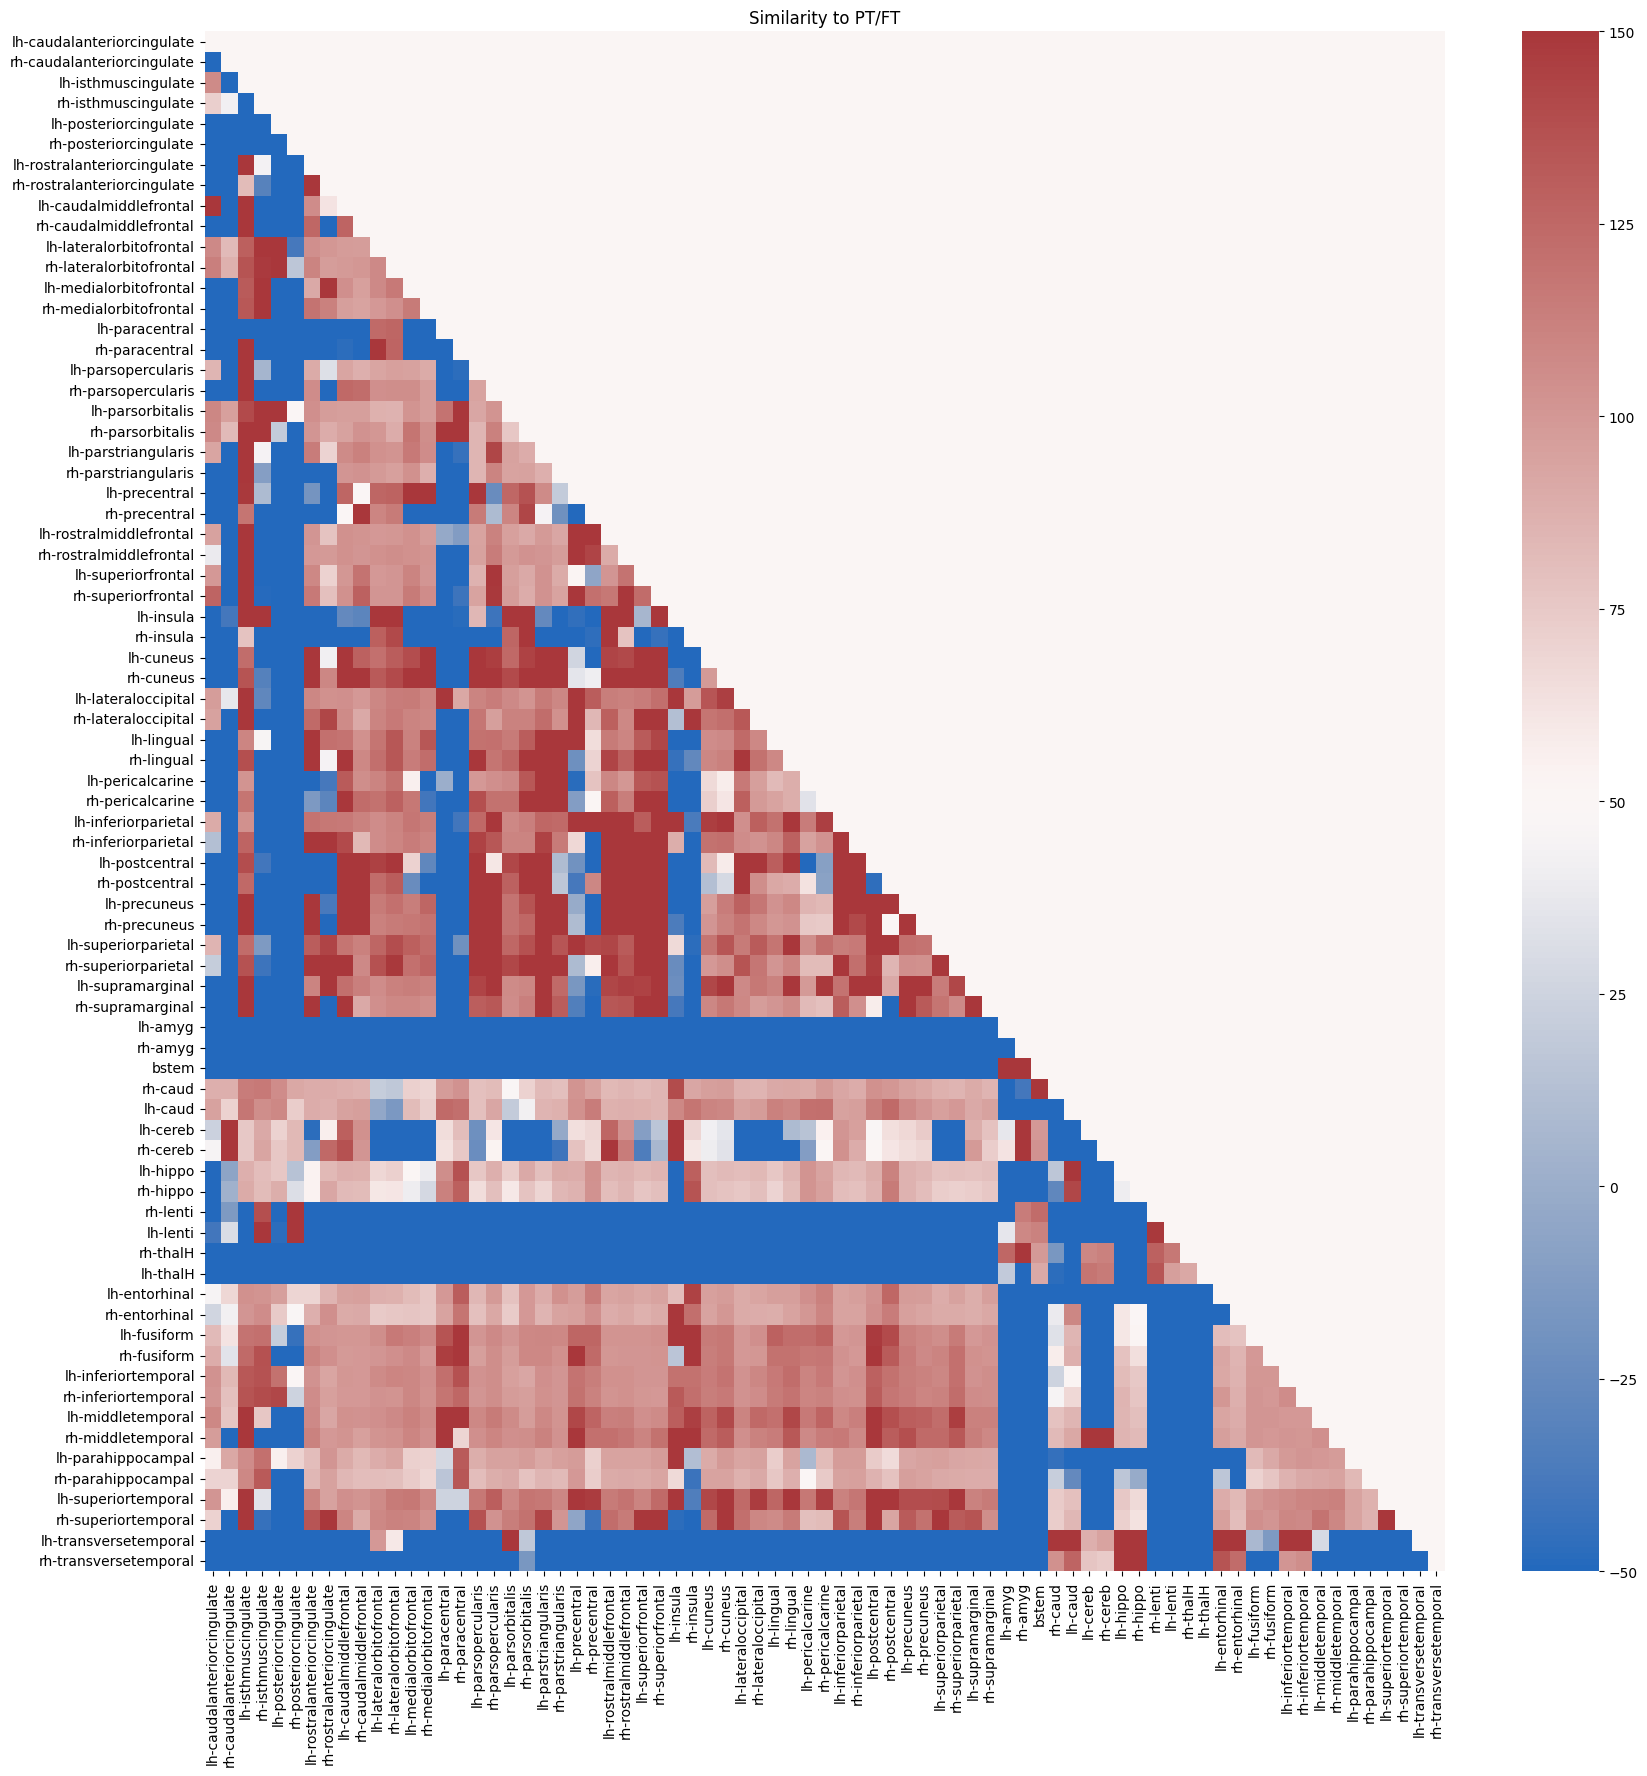

In [56]:
plot_diff = np.zeros_like(gc_group['PT: Ses1'].values)#.astype(str)
plot_diff[idx_d] = gc_values

fig, axs = plt.subplots(1,1, figsize=(20,20))
cmap = sns.color_palette("vlag", as_cmap=True)

#cmap = sns.blend_palette(["forestgreen", "1", "darkmagenta"], 3)
plot_diff = plot_diff + plot_diff.T - np.diag(np.diag(plot_diff))
s = plot_diff.take(order, 0)
s = s.take(order,1)

idx_f = np.triu_indices_from(plot_diff, k = 0)
s[idx_f] = 50

#s[s<0] = np.nan
#s[s>100] = np.nan

sns.heatmap(s, 
            xticklabels=relabeled_encoding['ROI'].values.take(order),
            yticklabels=relabeled_encoding['ROI'].values.take(order), cmap = cmap, center=50,  vmin=-50, vmax=150) 
c_bar = axs.collections[0].colorbar
#c_bar.set_ticks([-1, 1])
#c_bar.set_ticklabels(['PT', 'FT'], fontsize=20)

plt.title('Similarity to PT/FT')
#plt.savefig('../../Results/GC_FC_paper/figures/GC_prematurity_bounded.jpg', dpi=300)
plt.show()

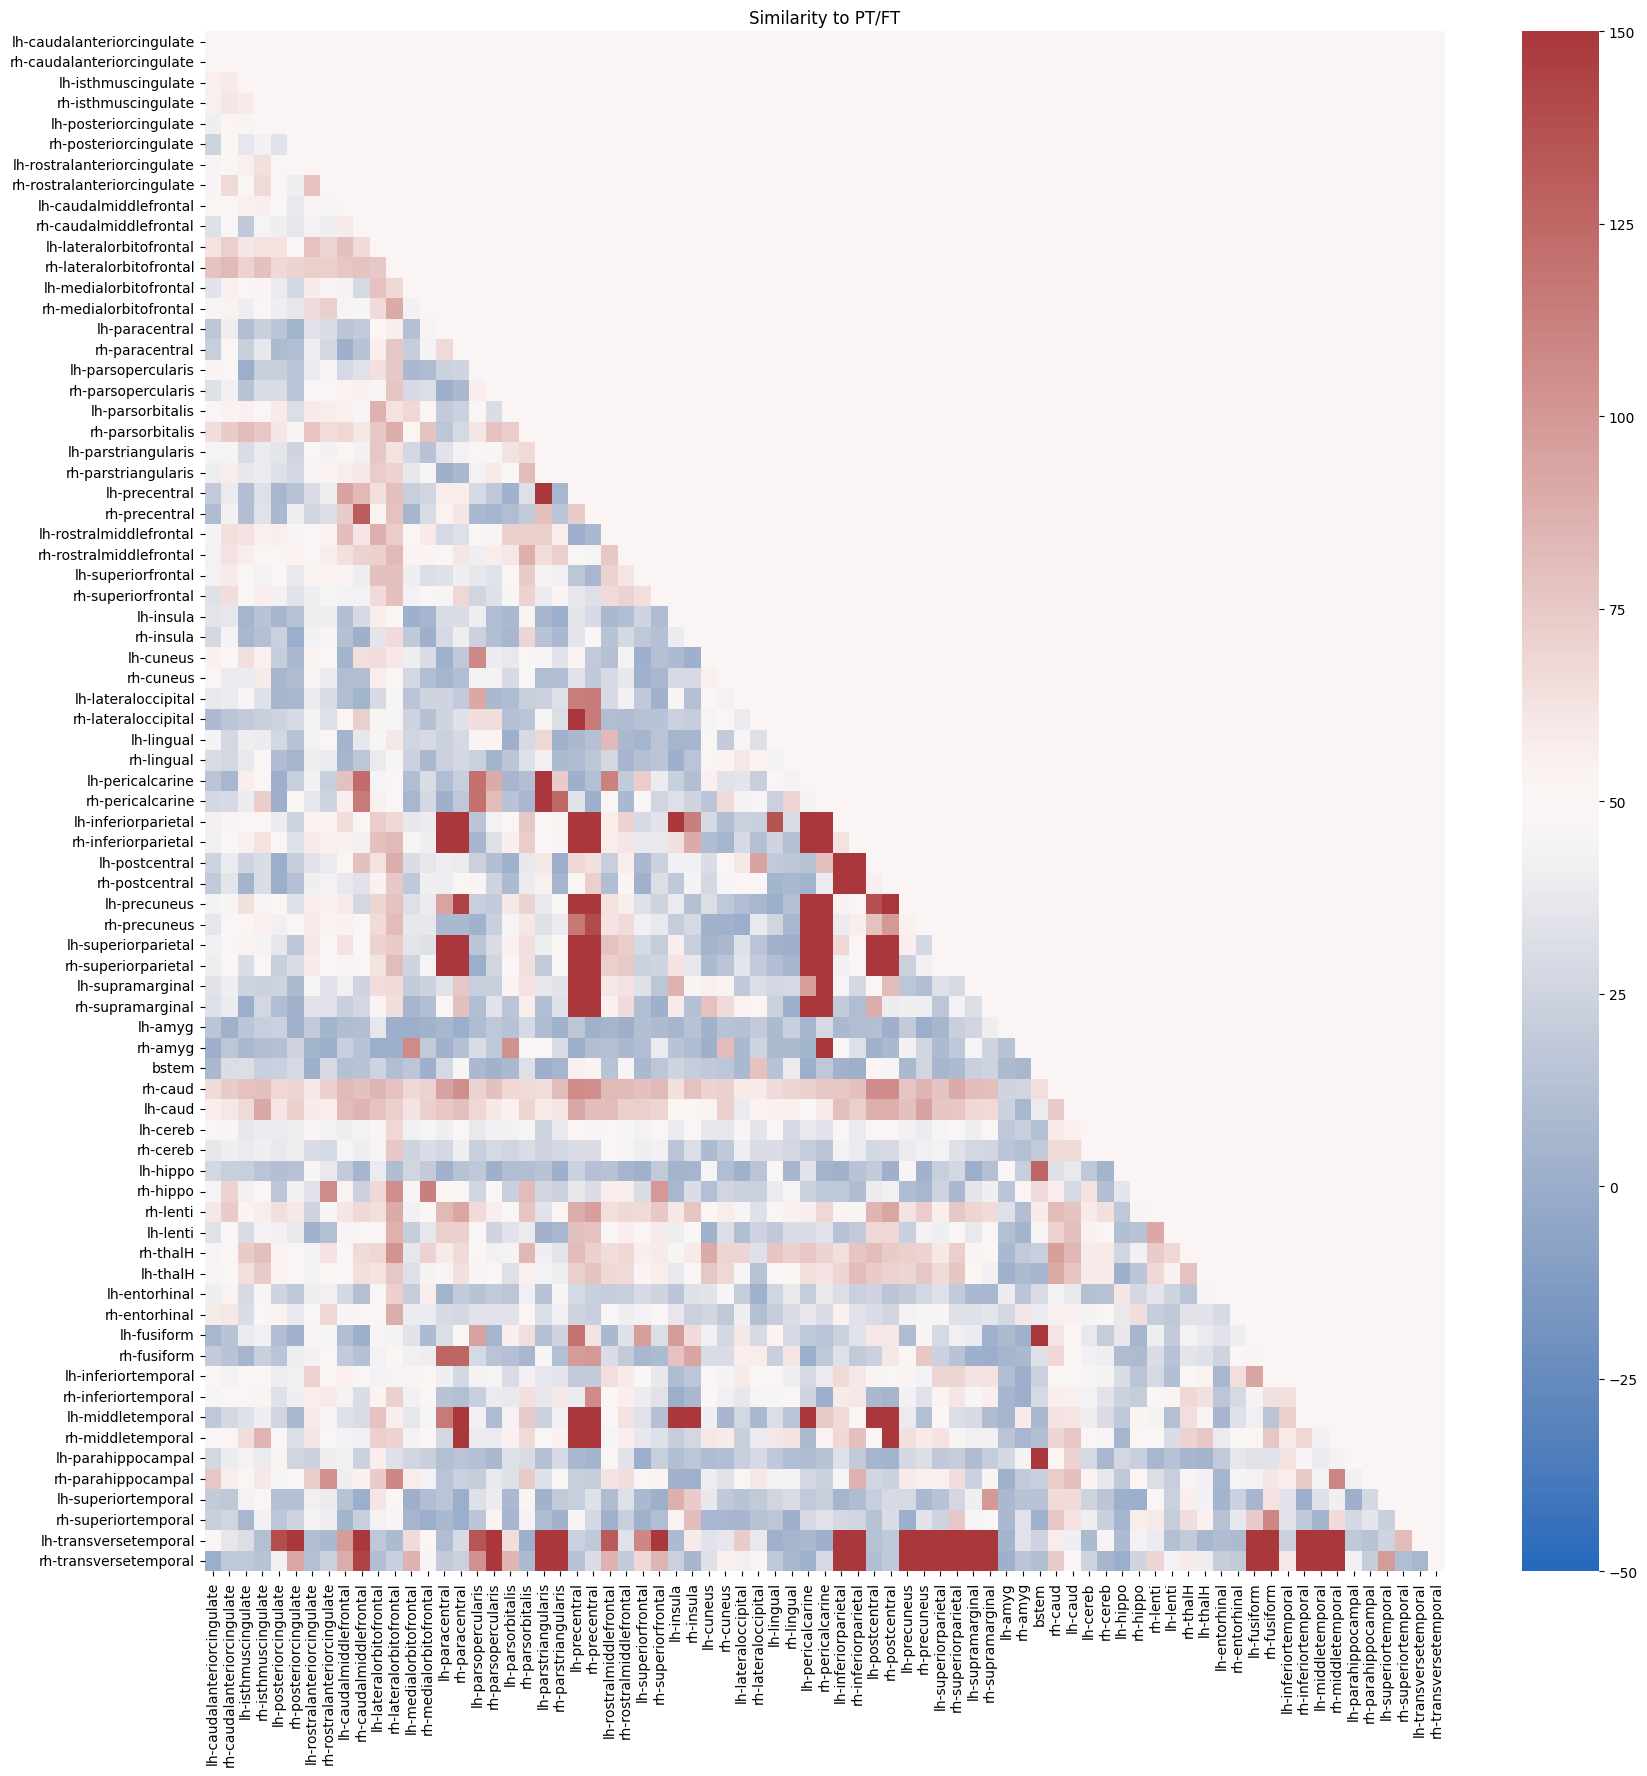

In [57]:
### bottom triangle
idx_d = np.tril_indices_from(fc_groups['PT: Ses1'], k = -1)

s1_values = np.round(fc_groups['PT: Ses1'][idx_d],3)
s2_values = np.round(fc_groups['PT: Ses2'][idx_d],3)
ft_values = np.round(fc_groups['FT'][idx_d],3)

fc_values = []
for x in range(len(s1_values)):
    norm = abs(ft_values[x] - s1_values[x])
    d_to_s1 =abs(s2_values[x] - s1_values[x])
    d_norm = (d_to_s1 / (norm + 0.00000000000001 ))*100
    fc_values.append(d_norm)
    
plot_diff = np.zeros_like(gc_group['PT: Ses1'].values)#.astype(str)
plot_diff[idx_d] = fc_values

fig, axs = plt.subplots(1,1, figsize=(20,20))
cmap = sns.color_palette("vlag", as_cmap=True)

#cmap = sns.blend_palette(["forestgreen", "1", "darkmagenta"], 3)
plot_diff = plot_diff + plot_diff.T - np.diag(np.diag(plot_diff))
s = plot_diff.take(order, 0)
s = s.take(order,1)

idx_f = np.triu_indices_from(plot_diff, k = 0)
s[idx_f] = 50

#s[s<0] = np.nan
#s[s>100] = np.nan

sns.heatmap(s, 
            xticklabels=relabeled_encoding['ROI'].values.take(order),
            yticklabels=relabeled_encoding['ROI'].values.take(order), cmap = cmap, center=50,  vmin=-50, vmax=150)

c_bar = axs.collections[0].colorbar
#c_bar.set_ticks([-1, 1])
#c_bar.set_ticklabels(['PT', 'FT'], fontsize=20)

plt.title('Similarity to PT/FT')
#plt.savefig('../../Results/GC_FC_paper/figures/FC_prematurity_bounded.jpg', dpi=300)
plt.show()

In [58]:
new_gc = np.array(gc_values)
new_gc[new_gc < 0 ]  = 0
new_gc[new_gc  > 100 ] = 100

new_fc = np.array(fc_values)
new_fc[new_fc < 0 ]  = 0
new_fc[new_fc  > 100 ] = 100

dif_prematurity = (np.array(gc_values) - np.array(fc_values))#/np.array(fc_values)


plot_diff = np.zeros_like(gc_group['PT: Ses1'].values)#.astype(str)
plot_diff[idx_d] =dif_prematurity 
plot_diff = plot_diff + plot_diff.T - np.diag(np.diag(plot_diff))

g = plot_diff.take(order, 0)
g = g.take(order,1)

idx_f = np.triu_indices_from(plot_diff, k = 0)
g[idx_f] = 0


In [59]:
dif_prematurity

array([   5.09156592, -143.49633636,  -92.2780127 , ..., -223.41166303,
       -106.48349662, -155.78514839])

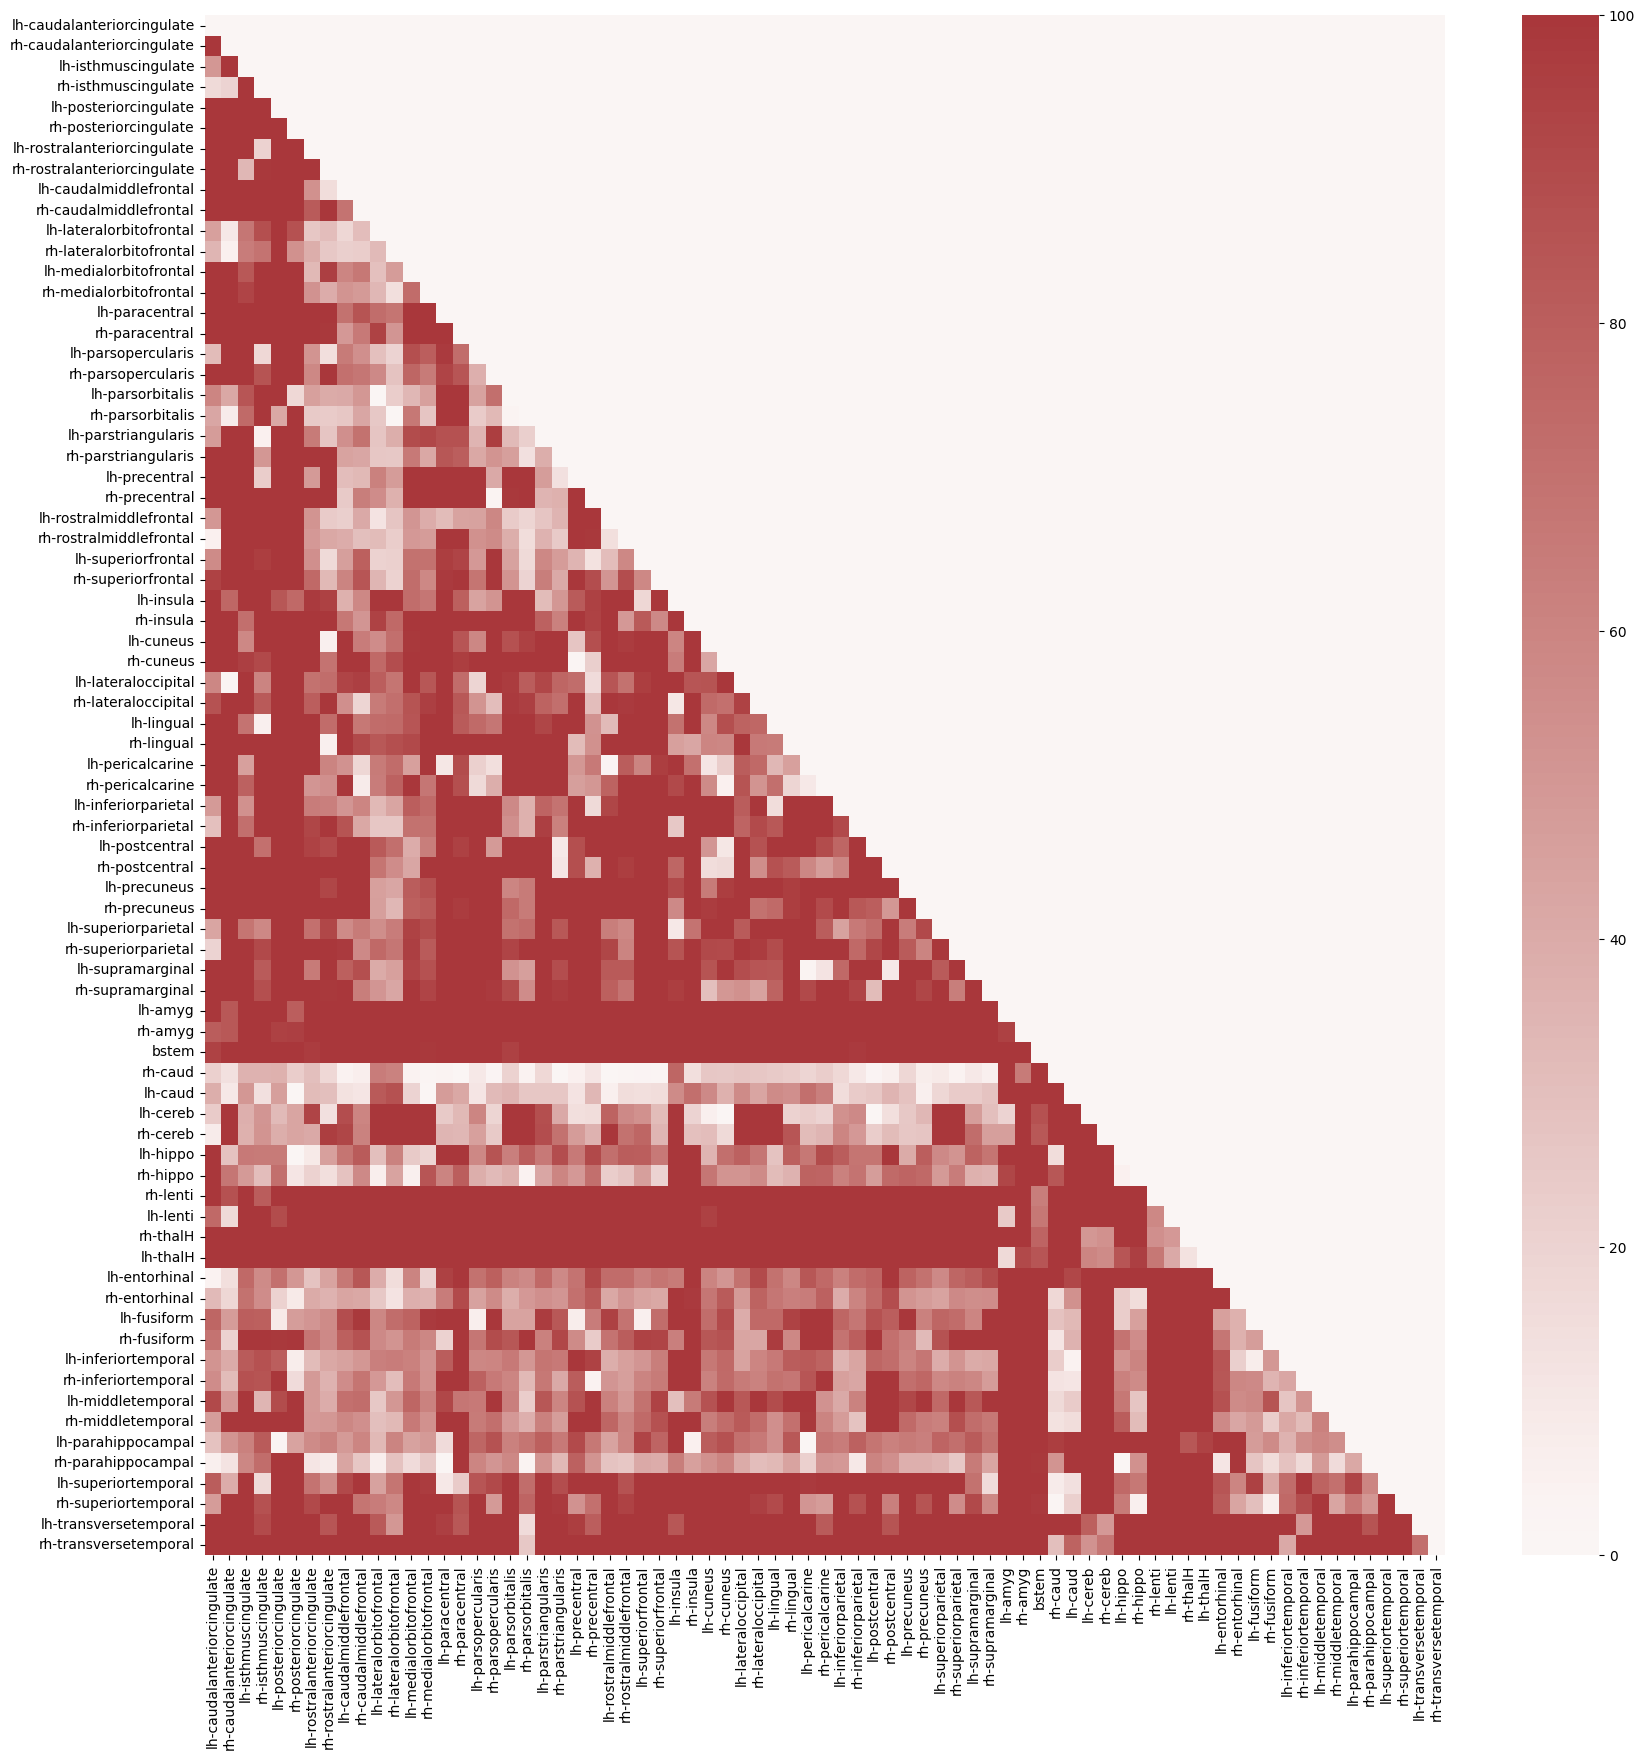

In [60]:
fig, axs = plt.subplots(1,1, figsize=(20,20))
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(abs(g),
            xticklabels=relabeled_encoding['ROI'].values.take(order),
            yticklabels=relabeled_encoding['ROI'].values.take(order),
            center=0,  vmin=0, vmax=100, cmap=cmap)
plt.savefig('../../Results/GC_FC_paper/figures/Prematurity_FC_GC_difference.jpg', dpi=300)
plt.show()

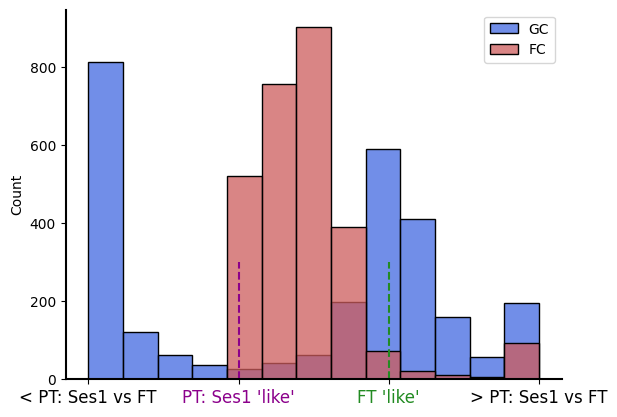

In [61]:
fig, ax = plt.subplots(1,1)

gc_cor = np.array(gc_values.copy())
gc_cor[gc_cor < -100] = -100
gc_cor[gc_cor > 200] = 200

fc_cor = np.array(fc_values.copy())
fc_cor[fc_cor < -100] = -100
fc_cor[fc_cor > 200] = 200


bins = np.histogram_bin_edges(gc_cor, bins='auto')

sns.histplot(gc_cor, color='royalblue',bins=bins, ax=ax, kde=False, label='GC')
sns.histplot(fc_cor, color='indianred',bins=bins, ax=ax, kde=False, label='FC')

plt.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)    

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)
    
plt.xticks([-100, 0,100, 200], ["< PT: Ses1 vs FT", "PT: Ses1 'like'", "FT 'like'", "> PT: Ses1 vs FT"], 
          fontsize=12)

my_colors = ['black', 'darkmagenta', 'forestgreen', 'black']

ax.plot([0,0], [0, 300], color='darkmagenta', linestyle='--')
ax.plot([100,100], [0, 300], color='forestgreen', linestyle='--')

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)

plt.show()

Text(0, 0.5, 'FC')

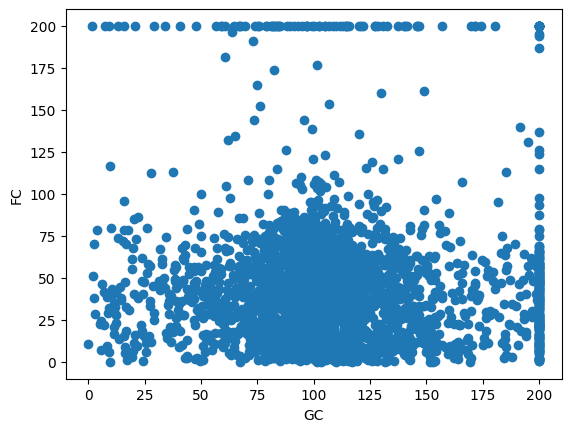

In [49]:
plt.scatter(gc_cor, fc_cor)
plt.xlabel('GC')
plt.ylabel('FC')

#plt.xlim(0, 100)
#plt.ylim(0, 100)